# Libraries

In [152]:
import jax
import jax.numpy as jnp
from functools import partial
import flax.linen as nn
import optax
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

# Representing Graphs

In [153]:
num_nodes = 4
node_features = jnp.array([
    [1.0, 0.5],  # Node 0 features
    [0.2, 0.8],  # Node 1 features
    [0.9, 0.1],  # Node 2 features
    [0.4, 0.6]  # Node 3 features
])

# Source nodes for each edge
senders = jnp.array([0, 1, 2, 3, 0])

# Destination nodes for each edge
receivers = jnp.array([1, 2, 0, 0, 3])

print(f"Node features shape: {node_features.shape}")
print(f"Senders: {senders}")
print(f"Receivers: {receivers}")

Node features shape: (4, 2)
Senders: [0 1 2 3 0]
Receivers: [1 2 0 0 3]


# Drawing the Graph

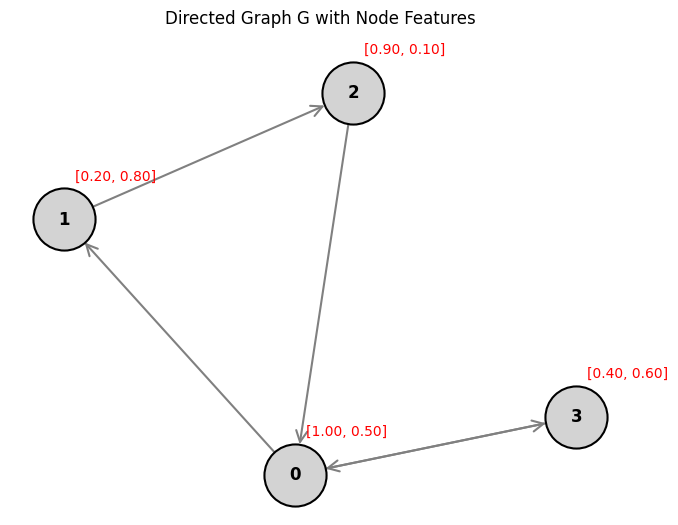

In [154]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create a directed graph object using networkx
G = nx.DiGraph()  # Use DiGraph for directed graphs

# 2. Add nodes with their features
for i in range(num_nodes):
    G.add_node(i, features=node_features[i].tolist())  # Convert JAX array to list for NetworkX attribute

# 3. Add edges
for s, r in zip(senders, receivers):
    G.add_edge(int(s), int(r))  # Ensure indices are standard Python ints

# 4. Define drawing parameters
pos = nx.spring_layout(G, seed=42)  # Layout nodes using a spring model for better visualization
# You could manually define positions if you want exact placement like your schematic:
# pos = {0: (0, 0), 1: (1, 1), 2: (1, -1), 3: (2, 0)} # Example manual positions if desired

node_labels = {i: str(i) for i in G.nodes()}  # Labels for node IDs
feature_labels = {
    i: '[' + ', '.join([f"{f:.2f}" for f in G.nodes[i]['features']]) + ']'
    for i in G.nodes()
}

# 5. Draw the graph
plt.figure(figsize=(8, 6))

# Use nx.draw_networkx for comprehensive drawing
nx.draw_networkx(
    G,
    pos,
    labels=node_labels,  # Node IDs as labels
    node_color='lightgray',
    node_size=2000,
    edgecolors='black',
    linewidths=1.5,
    arrowstyle='->',
    arrowsize=20,
    edge_color='gray',
    width=1.5,
    font_size=12,
    font_weight='bold'
)

# Add node feature labels (slightly offset)
for node, (x, y) in pos.items():
    plt.text(x + 0.2, y + 0.1, feature_labels[node], fontsize=10, color='red', ha='center')

plt.title("Directed Graph G with Node Features\n")
plt.axis('off')  # Hide axes
plt.show()

# Basic GNN Layer

In [155]:
class BasicGNNLayer(nn.Module):
    # The desired output feature dimension for each node
    output_features: int

    @nn.compact
    def __call__(
            self,
            node_features: jnp.array,
            senders: jnp.array,
            receivers: jnp.array,
            num_nodes: int
    ):
        """
        Performs one round of message passing.

        Args:
            node_features: A JAX array of shape (num_nodes, input_features_dim)
                           representing initial node features.
            senders: A JAX array of shape (num_edges,) indicating source nodes
                            for each edge.
            receivers: A JAX array of shape (num_edges,) indicating destination
                            nodes for each edge.
            num_nodes: An integer, the total number of nodes in the graph.

        Returns:
            A JAX array of shape (num_nodes, output_features) with
            updated node features.
        """
        # 1. Message Generation
        messages = nn.Dense(
            features=self.output_features,
            name="message_transform"
        )(node_features)
        edge_messages = messages[senders]

        # 2. Message Aggregation:
        # Sum messages arriving at each node
        aggregated_messages = jax.ops.segment_sum(
            data=edge_messages,
            segment_ids=receivers,
            num_segments=num_nodes
        )

        # 3. Node Update:
        transformed_original_features = nn.Dense(
            features=self.output_features,
            name="self_transform"
        )(node_features)

        # A common update is to combine aggregated messages and transformed self-features
        # Let's sum them for simplicity, then apply a non-linearity
        updated_features = transformed_original_features + aggregated_messages

        # Apply a non-linear activation
        updated_features = nn.relu(updated_features)

        return updated_features


In [156]:
class MultiLayerGNN(nn.Module):
    # Number of GNN layers to stack
    num_layers: int
    # Feature dimension for hidden layers
    hidden_features: int
    # Final output feature dimension
    output_features: int

    @nn.compact
    def __call__(
            self,
            node_features: jnp.array,
            senders: jnp.array,
            receivers: jnp.array,
            num_nodes: int
    ):
        # Pass node features through BasicGNNLayer
        x = node_features

        for i in range(self.num_layers - 1):
            x = BasicGNNLayer(
                output_features=self.hidden_features,
                name=f"gnn_layer_{i}"
            )(x, senders, receivers, num_nodes)

        # Output Layer
        x = BasicGNNLayer(
            output_features=self.output_features,
            name="gnn_output_layer"
        )(x, senders, receivers, num_nodes)

        return x


In [157]:
# Define the model architecture
# e.g., 3 output classes
model = MultiLayerGNN(num_layers=2, hidden_features=16, output_features=3)

# Initialize the model parameters
key = jax.random.PRNGKey(0)
params = model.init(
    key,
    node_features,
    senders,
    receivers,
    num_nodes
)['params']

print("Model initialized. Parameters structure:")
params_shapes_dict = jax.tree_util.tree_map(lambda x: list(x.shape), params)
print(json.dumps(params_shapes_dict, indent=4))

# Perform a forward pass
output_node_embeddings = model.apply(
    {'params': params},
    node_features,
    senders,
    receivers,
    num_nodes
)

print(f"\nInput node features shape: {node_features.shape}")
print(f"Output node embeddings shape: {output_node_embeddings.shape}")
print("\nFirst few output embeddings:\n", output_node_embeddings[:2])

Model initialized. Parameters structure:
{
    "gnn_layer_0": {
        "message_transform": {
            "bias": [
                16
            ],
            "kernel": [
                2,
                16
            ]
        },
        "self_transform": {
            "bias": [
                16
            ],
            "kernel": [
                2,
                16
            ]
        }
    },
    "gnn_output_layer": {
        "message_transform": {
            "bias": [
                3
            ],
            "kernel": [
                16,
                3
            ]
        },
        "self_transform": {
            "bias": [
                3
            ],
            "kernel": [
                16,
                3
            ]
        }
    }
}

Input node features shape: (4, 2)
Output node embeddings shape: (4, 3)

First few output embeddings:
 [[0.         1.3855482  0.7500067 ]
 [0.         0.8564396  0.91308314]]


# Toy Dataset

In [158]:
# --- Synthetic Dataset Generation ---
def generate_synthetic_graph(
        num_nodes=100,
        num_classes=3,
        edges_per_node=2,
        feature_dim=10,
        seed=0
):
    key = jax.random.PRNGKey(seed)

    # 1. Generate Node Features: Random features for each node
    key, subkey = jax.random.split(key)
    node_features = jax.random.normal(subkey, (num_nodes, feature_dim))

    # 2. Assign Node Labels: Distribute nodes into classes
    key, subkey = jax.random.split(key)
    # Ensure roughly equal distribution
    node_labels = jax.random.randint(
        subkey,
        (num_nodes,),
        minval=0,
        maxval=num_classes
    )

    # 3. Generate Edges: Preferential attachment within classes
    senders = []
    receivers = []
    for i in range(num_nodes):
        # Connect to nodes in the same class
        same_class_nodes = jnp.where(
            node_labels == node_labels[i]
        )[0]

        # Ensure we don't pick self as neighbor for edges,
        # unless specifically intended for self-loops later
        same_class_nodes = same_class_nodes[same_class_nodes != i]

        if len(same_class_nodes) > 0:
            key, subkey = jax.random.split(key)
            # Pick 'edges_per_node' neighbors from same class,
            # or fewer if not enough available
            num_neighbors = min(edges_per_node, len(same_class_nodes))
            # Use choice with replacement if
            # num_neighbors > len(same_class_nodes)
            chosen_neighbors = jax.random.choice(
                subkey,
                same_class_nodes,
                shape=(num_neighbors,),
                replace=True
            )
            for neighbor_idx in chosen_neighbors:
                senders.append(i)
                receivers.append(neighbor_idx)
                # For undirected graph, add reverse edge as well
                senders.append(neighbor_idx)
                receivers.append(i)

    # Convert lists to JAX arrays
    senders = jnp.array(senders, dtype=jnp.int32)
    receivers = jnp.array(receivers, dtype=jnp.int32)

    # Add self-loops (crucial for GCN-like behavior where
    # nodes integrate their own features)
    self_loop_senders = jnp.arange(num_nodes, dtype=jnp.int32)
    self_loop_receivers = jnp.arange(num_nodes, dtype=jnp.int32)
    senders = jnp.concatenate([senders, self_loop_senders])
    receivers = jnp.concatenate([receivers, self_loop_receivers])


    return node_features, senders, receivers, num_nodes, node_labels


## Generate the graph

In [159]:
NUM_NODES = 100
NUM_CLASSES = 3
FEATURE_DIM = 16 # Input feature dimension for nodes

node_features, senders, receivers, num_nodes, node_labels = generate_synthetic_graph(
    num_nodes=NUM_NODES,
    num_classes=NUM_CLASSES,
    edges_per_node=3, # Average 3 in-class neighbors
    feature_dim=FEATURE_DIM,
    seed=42
)

print(f"Node features shape: {node_features.shape}")
print(f"Senders shape: {senders.shape}")
print(f"Receivers shape: {receivers.shape}")
print(f"Number of nodes: {num_nodes}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Node Labels shape {node_labels.shape}")
print(f"Node Labels:\n {node_labels}")

Node features shape: (100, 16)
Senders shape: (700,)
Receivers shape: (700,)
Number of nodes: 100
Number of classes: 3
Node Labels shape (100,)
Node Labels:
 [2 0 2 0 1 1 0 0 1 0 0 0 1 2 2 0 2 1 2 1 0 1 0 0 2 1 0 2 0 0 0 2 0 1 0 1 0
 0 1 1 2 2 0 0 2 0 1 2 2 0 0 0 0 2 0 1 2 0 0 0 0 0 0 2 1 0 1 1 1 1 0 1 0 2
 1 2 2 0 2 1 0 2 1 1 1 1 2 2 0 0 2 1 1 1 1 1 1 1 1 1]


In [160]:
idx = jnp.arange(num_nodes)
key, subkey1, subkey2 = jax.random.split(jax.random.PRNGKey(0), 3)

# First split - train/test
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

# Second split - train/validation
# 25% of 80% = 20% for validation
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

train_mask = jnp.zeros(num_nodes, dtype=jnp.bool_).at[train_idx].set(True)
val_mask = jnp.zeros(num_nodes, dtype=jnp.bool_).at[val_idx].set(True)
test_mask = jnp.zeros(num_nodes, dtype=jnp.bool_).at[test_idx].set(True)

train_mask = train_mask.at[train_idx].set(True)

print(f"Generated Graph: {num_nodes} nodes, {len(senders)} edges (including self-loops)")
print(f"Node features shape: {node_features.shape}")
print(f"Node labels shape: {node_labels.shape}")
print(f"Train nodes: {jnp.sum(train_mask)}")
print(f"Val nodes: {jnp.sum(val_mask)}")
print(f"Test nodes: {jnp.sum(test_mask)}")
print(f"Example of validation nodes:\n{node_features[val_mask][:2]}")

Generated Graph: 100 nodes, 700 edges (including self-loops)
Node features shape: (100, 16)
Node labels shape: (100,)
Train nodes: 60
Val nodes: 20
Test nodes: 20
Example of validation nodes:
[[-0.30395982  0.3939658  -0.87947404 -2.4562614   0.93186224 -0.94133425
   0.4705041  -0.5682559  -0.03568491  0.6551425  -0.6771544  -0.22431315
  -0.98438984 -2.0855458   1.8307798   0.37856096]
 [ 0.8829633  -0.2824106  -0.27737394  1.1645578   0.21666679 -0.38737997
  -0.45600188  1.1401342  -0.56761235  0.7668255  -0.96149266  0.02561626
   0.34861353 -0.9245324   0.2842167  -1.3863764 ]]


## Loss Function and Optimizer

In [161]:
# define the loss function
@jax.jit
def cross_entropy_loss(
        logits: jnp.ndarray,
        labels: jnp.ndarray,
        mask: jnp.ndarray
):
    one_hot_labels = jax.nn.one_hot(
        labels,
        num_classes=logits.shape[-1]
    )

    # Apply softmax cross-entropy, then average over masked entries
    loss = -jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis=-1)

    # Only consider loss for masked nodes
    masked_loss = jnp.where(mask, loss, 0.0)

    # Average over relevant nodes
    return jnp.sum(masked_loss) / jnp.sum(mask)

In [162]:
@jax.jit
def accuracy(
        logits: jnp.ndarray,
        labels: jnp.ndarray,
        mask: jnp.ndarray
):
    preds = jnp.argmax(logits, axis=-1)
    correc_preds = jnp.where(
        mask,
        preds == labels,
        False
    )
    return jnp.sum(correc_preds) / jnp.sum(mask)

In [163]:
learning_rate = 0.01
optimizer = optax.adam(learning_rate)

## Training Loop

In [164]:
NUM_GNN_LAYERS = 2
HIDDEN_DIM = 32

# Initialize model
model = MultiLayerGNN(
    num_layers= NUM_GNN_LAYERS,
    hidden_features=HIDDEN_DIM,
    output_features=NUM_CLASSES
)

# initialize parameters
key = jax.random.PRNGKey(42)
params = model.init(
    key,
    node_features,
    senders,
    receivers,
    num_nodes
)['params']

# initialize optimizer state
opt_state = optimizer.init(params)

In [165]:
@partial(jax.jit, static_argnames=['num_nodes'])
def train_step(
        params,
        opt_state,
        node_features,
        senders,
        receivers,
        num_nodes, # Index 5
        labels,
        train_mask
):
    def loss_fn(current_params):
        # Forward pass: get logits
        logits = model.apply(
            {'params': current_params},
            node_features,
            senders,
            receivers,
            num_nodes
        )

        # Calculate loss on training nodes
        loss = cross_entropy_loss(
            logits,
            labels,
            train_mask
        )
        return loss, logits

    # Compute gradients and loss
    (loss, logits), grads = jax.value_and_grad(
        loss_fn,
        has_aux=True
    )(params)

    # Update model parameters
    updates, new_opt_state = optimizer.update(
        grads, opt_state, params
    )
    new_params = optax.apply_updates(
        params,
        updates
    )

    # Calculate training accuracy
    train_acc = accuracy(
        logits,
        labels,
        train_mask
    )

    return new_params, new_opt_state, loss, train_acc

In [166]:
@partial(jax.jit, static_argnames=['num_nodes'])
def eval_step(
        params,
        node_features,
        senders,
        receivers,
        num_nodes, # index 4
        labels,
        mask
):
    logits = model.apply(
        {'params': params},
        node_features,
        senders,
        receivers,
        num_nodes
    )
    val_loss = cross_entropy_loss(logits, labels, mask)
    val_acc = accuracy(logits, labels, mask)
    return val_loss, val_acc

In [167]:
EPOCHS = 100
print("\nStart training...")
for epoch in range(EPOCHS):
    params, opt_state, train_loss, train_acc = train_step(
        params,
        opt_state,
        node_features,
        senders,
        receivers,
        num_nodes,
        node_labels,
        train_mask
    )

    if (epoch + 1) % 10 == 0:
        eval_loss, eval_acc = eval_step(
            params,
            node_features,
            senders,
            receivers,
            num_nodes,
            node_labels,
            val_mask
        )
        print(
            f"Epoch {epoch+1:03d} | \
            Train Loss: {train_loss:.4f} | \
            Train Acc: {train_acc:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | \
            Eval Acc: {eval_acc:.4f}"
        )

print("\nTraining complete!")
final_test_loss, final_test_acc = eval_step(
    params,
    node_features,
    senders,
    receivers,
    num_nodes,
    node_labels,
    test_mask
)
print(
    f"Final Test Loss: {final_test_loss:.4f} |\ "
    f"Final Test Acc: {final_test_acc:.4f}"
)


Start training...
Epoch 010 |             Train Loss: 0.1960 |             Train Acc: 0.9167 | Eval Loss: 0.1402 |             Eval Acc: 0.9500
Epoch 020 |             Train Loss: 0.0023 |             Train Acc: 1.0000 | Eval Loss: 0.0115 |             Eval Acc: 1.0000
Epoch 030 |             Train Loss: 0.0002 |             Train Acc: 1.0000 | Eval Loss: 0.0043 |             Eval Acc: 1.0000
Epoch 040 |             Train Loss: 0.0000 |             Train Acc: 1.0000 | Eval Loss: 0.0028 |             Eval Acc: 1.0000
Epoch 050 |             Train Loss: 0.0000 |             Train Acc: 1.0000 | Eval Loss: 0.0024 |             Eval Acc: 1.0000
Epoch 060 |             Train Loss: 0.0000 |             Train Acc: 1.0000 | Eval Loss: 0.0022 |             Eval Acc: 1.0000
Epoch 070 |             Train Loss: 0.0000 |             Train Acc: 1.0000 | Eval Loss: 0.0022 |             Eval Acc: 1.0000
Epoch 080 |             Train Loss: 0.0000 |             Train Acc: 1.0000 | Eval Loss: 0.0021 |   

In [168]:
test_logits = model.apply(
    {'params': params},
    node_features,
    senders,
    receivers,
    num_nodes
)

test_predictions = jnp.argmax(test_logits, axis=-1)
test_probabilities = jax.nn.softmax(test_logits, axis=-1)

print("\n--- Inference Results ---")
test_indices = jnp.where(test_mask)[0]

for i, node_idx in enumerate(test_indices[:10]):
    true_label = node_labels[node_idx]
    pred_label = test_predictions[node_idx]
    confidence = test_probabilities[node_idx, pred_label]
    print(
        f"Node {node_idx}: True={true_label}, \
        Pred={pred_label}, \
        Confidence={confidence:.3f}"
    )

# Print confusion matrix-style summary
print(f"\nPrediction Summary:")
print(f"Correct predictions: {jnp.sum(test_predictions[test_mask] == node_labels[test_mask])}/{jnp.sum(test_mask)}")

# Show prediction distribution
for class_id in range(NUM_CLASSES):
  class_preds = jnp.sum(test_predictions[test_mask] == class_id)
  class_true = jnp.sum(node_labels[test_mask] == class_id)
  print(f"Class {class_id}: {class_preds} predicted, {class_true} actual")


--- Inference Results ---
Node 0: True=2,         Pred=2,         Confidence=1.000
Node 4: True=1,         Pred=1,         Confidence=1.000
Node 10: True=0,         Pred=0,         Confidence=1.000
Node 12: True=1,         Pred=1,         Confidence=1.000
Node 18: True=2,         Pred=2,         Confidence=1.000
Node 22: True=0,         Pred=0,         Confidence=1.000
Node 30: True=0,         Pred=0,         Confidence=1.000
Node 31: True=2,         Pred=2,         Confidence=1.000
Node 33: True=1,         Pred=1,         Confidence=1.000
Node 39: True=1,         Pred=1,         Confidence=1.000

Prediction Summary:
Correct predictions: 20/20
Class 0: 7 predicted, 7 actual
Class 1: 5 predicted, 5 actual
Class 2: 8 predicted, 8 actual


# Benchmark Dataset

In [169]:
import torch_geometric
from torch_geometric.datasets import Planetoid, CitationFull


In [170]:
cora_dataset = torch_geometric.datasets.Planetoid(root="/tmp/Cora", name="Cora")
cora_dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [171]:
cora_dataset[0]['edge_index'][1].shape

torch.Size([10556])

In [172]:
cora_dataset[0]['x'][0][90:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [173]:
def load_cora():
      dataset = Planetoid(root='/tmp/Cora', name='Cora')
      data = dataset[0]

      # Convert to JAX format
      node_features = jnp.array(data.x.numpy())
      edge_index = data.edge_index.numpy()
      senders = jnp.array(edge_index[0])
      receivers = jnp.array(edge_index[1])
      labels = jnp.array(data.y.numpy())

      # Train/val/test masks
      train_mask = jnp.array(data.train_mask.numpy())
      val_mask = jnp.array(data.val_mask.numpy())
      test_mask = jnp.array(data.test_mask.numpy())

      return node_features, senders, receivers, len(node_features), labels, train_mask, val_mask, test_mask

node_features, senders, receivers, num_nodes, labels, train_mask, val_mask, test_mask = load_cora()

print(f"Node features shape: {node_features.shape}")
print(f"Senders shape: {senders.shape}")
print(f"Receivers shape: {receivers.shape}")
print(f"Number of nodes: {num_nodes}")
print(f"Number of classes: {jnp.unique(labels).size}")
print(f"Node Labels shape {labels.shape}")
print(f"Node Labels:\n {labels}")

Node features shape: (2708, 1433)
Senders shape: (10556,)
Receivers shape: (10556,)
Number of nodes: 2708
Number of classes: 7
Node Labels shape (2708,)
Node Labels:
 [3 4 4 ... 3 3 3]


In [174]:
print(f"Generated Graph: {num_nodes} nodes, {len(senders)} edges (including self-loops)")
print(f"Node features shape: {node_features.shape}")
print(f"Node labels shape: {node_labels.shape}")
print(f"Train nodes: {jnp.sum(train_mask)}")
print(f"Val nodes: {jnp.sum(val_mask)}")
print(f"Test nodes: {jnp.sum(test_mask)}")
print(f"Example of train nodes:\n{node_features[train_mask][:10]}")

Generated Graph: 2708 nodes, 10556 edges (including self-loops)
Node features shape: (2708, 1433)
Node labels shape: (100,)
Train nodes: 140
Val nodes: 500
Test nodes: 1000
Example of train nodes:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [191]:
NUM_GNN_LAYERS = 20
HIDDEN_DIM = 32
NUM_CLASSES = jnp.unique(labels).size

learning_rate = 0.001
optimizer = optax.adam(learning_rate)

# Initialize model
model = MultiLayerGNN(
    num_layers= NUM_GNN_LAYERS,
    hidden_features=HIDDEN_DIM,
    output_features=NUM_CLASSES
)

# initialize parameters
key = jax.random.PRNGKey(42)
params = model.init(
    key,
    node_features,
    senders,
    receivers,
    num_nodes
)['params']

# initialize optimizer state
opt_state = optimizer.init(params)

In [192]:
EPOCHS = 1000
print("\nStart training...")
for epoch in range(EPOCHS):
    params, opt_state, train_loss, train_acc = train_step(
        params,
        opt_state,
        node_features,
        senders,
        receivers,
        num_nodes,
        labels,
        train_mask
    )

    if (epoch + 1) % 10 == 0:
        eval_loss, eval_acc = eval_step(
            params,
            node_features,
            senders,
            receivers,
            num_nodes,
            labels,
            val_mask
        )
        print(
            f"Epoch {epoch+1:03d} | \
            Train Loss: {train_loss:.4f} | \
            Train Acc: {train_acc:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | \
            Eval Acc: {eval_acc:.4f}"
        )

print("\nTraining complete!")
final_test_loss, final_test_acc = eval_step(
    params,
    node_features,
    senders,
    receivers,
    num_nodes,
    labels,
    test_mask
)
print(
    f"Final Test Loss: {final_test_loss:.4f} |\ "
    f"Final Test Acc: {final_test_acc:.4f}"
)


Start training...
Epoch 010 |             Train Loss: 9409387508531200.0000 |             Train Acc: 0.1500 | Eval Loss: 4370992512106496.0000 |             Eval Acc: 0.0540
Epoch 020 |             Train Loss: 3640132422860800.0000 |             Train Acc: 0.1143 | Eval Loss: 2770181965217792.0000 |             Eval Acc: 0.1780
Epoch 030 |             Train Loss: 3540068543234048.0000 |             Train Acc: 0.1571 | Eval Loss: 1843498210820096.0000 |             Eval Acc: 0.1820
Epoch 040 |             Train Loss: 2039353282920448.0000 |             Train Acc: 0.1500 | Eval Loss: 2628236517310464.0000 |             Eval Acc: 0.1120
Epoch 050 |             Train Loss: 1520207164080128.0000 |             Train Acc: 0.1500 | Eval Loss: 1063457390592000.0000 |             Eval Acc: 0.1760
Epoch 060 |             Train Loss: 1552809455517696.0000 |             Train Acc: 0.1571 | Eval Loss: 754157401145344.0000 |             Eval Acc: 0.2040
Epoch 070 |             Train Loss: 9319562965

In [193]:
test_logits = model.apply(
    {'params': params},
    node_features,
    senders,
    receivers,
    num_nodes
)

test_predictions = jnp.argmax(test_logits, axis=-1)
test_probabilities = jax.nn.softmax(test_logits, axis=-1)

print("\n--- Inference Results ---")
test_indices = jnp.where(test_mask)[0]

for i, node_idx in enumerate(test_indices[:10]):
    true_label = labels[node_idx]
    pred_label = test_predictions[node_idx]
    confidence = test_probabilities[node_idx, pred_label]
    print(
        f"Node {node_idx}: True={true_label}, \
        Pred={pred_label}, \
        Confidence={confidence:.3f}"
    )

# Print confusion matrix-style summary
print(f"\nPrediction Summary:")
print(f"Correct predictions: {jnp.sum(test_predictions[test_mask] == labels[test_mask])}/{jnp.sum(test_mask)}")

# Show prediction distribution
for class_id in range(jnp.unique(labels).size):
  class_preds = jnp.sum(test_predictions[test_mask] == class_id)
  class_true = jnp.sum(labels[test_mask] == class_id)
  print(f"Class {class_id}: {class_preds} predicted, {class_true} actual")


--- Inference Results ---
Node 1708: True=3,         Pred=0,         Confidence=0.143
Node 1709: True=2,         Pred=0,         Confidence=0.143
Node 1710: True=2,         Pred=0,         Confidence=0.143
Node 1711: True=2,         Pred=0,         Confidence=0.143
Node 1712: True=2,         Pred=0,         Confidence=0.143
Node 1713: True=0,         Pred=0,         Confidence=0.143
Node 1714: True=2,         Pred=0,         Confidence=0.143
Node 1715: True=2,         Pred=0,         Confidence=0.143
Node 1716: True=2,         Pred=0,         Confidence=0.143
Node 1717: True=2,         Pred=0,         Confidence=0.143

Prediction Summary:
Correct predictions: 147/1000
Class 0: 929 predicted, 130 actual
Class 1: 0 predicted, 91 actual
Class 2: 2 predicted, 144 actual
Class 3: 10 predicted, 319 actual
Class 4: 28 predicted, 149 actual
Class 5: 0 predicted, 103 actual
Class 6: 31 predicted, 64 actual
